# Emotion Recognition
Kaggle Facial Expression Recognition

In [ ]:
# Keras for TensorFlow
from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.contrib.keras.python.keras.optimizers import Adam, RMSprop
from tensorflow.contrib.keras.python.keras.callbacks import EarlyStopping
from tensorflow.contrib.keras.python.keras.regularizers import l1, l2
# from tensorflow.contrib.keras.python.keras.applications.resnet50 import ResNet50

import cv2
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
n_inputs = 2304
n_classes = 7
img_dim = 48

In [ ]:
def get_emotion(ohv):
    if ohv.shape[0] == 1:
        indx = ohv[0]
    else:
        indx = np.argmax(ohv)
        
    if indx == 0:
        return 'angry'
    elif indx == 1:
        return 'disgust'
    elif indx == 2:
        return 'fear'
    elif indx == 3:
        return 'happy'
    elif indx == 4:
        return 'sad'
    elif indx == 5:
        return 'surprise'
    elif indx == 6:
        return 'neutral'

In [ ]:
def predict_emotion_from_image(model, img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (48, 48))
    img = img.reshape([1, 48, 48, 1])
    
    pred_cls = model.predict_classes(img, verbose=0)
    proba = model.predict(img, verbose=0)
    
    return np.max(proba), pred_cls

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape = (48, 48, 1)))

model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

model.add(Conv2D(128, (3, 3), activation='relu'))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

model.add(Conv2D(256, (3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

In [ ]:
opt = Adam(lr=0.0001, decay=10e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
model.load_weights('fer2013_weights_.h5')
print('> model loaded')

# Tiny Face Detector
https://github.com/peiyunh/tiny  
https://github.com/chinakook/hr101_mxnet

In [1]:
import mxnet as mx
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.io as sio
import pylab as pl
from collections import namedtuple
import time
Batch = namedtuple('Batch', ['data'])

In [2]:
MAX_INPUT_DIM=5000.0
prob_thresh = 0.5
nms_thresh = 0.1

In [3]:
def loadmeta(matpath):
    f = sio.loadmat(matpath)
    net = f['net']
    clusters = np.copy(net['meta'][0][0][0][0][6])
    averageImage = np.copy(net['meta'][0][0][0][0][2][0][0][2])
    averageImage = averageImage[:, np.newaxis]
    return clusters, averageImage

In [4]:
def nms(dets, prob_thresh):
    x1 = dets[:, 0]  
    y1 = dets[:, 1]  
    x2 = dets[:, 2]  
    y2 = dets[:, 3]  
    scores = dets[:, 4]  
    
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)  

    order = scores.argsort()[::-1]  

    keep = []  
    while order.size > 0: 
        i = order[0]  
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])  
        yy1 = np.maximum(y1[i], y1[order[1:]])  
        xx2 = np.minimum(x2[i], x2[order[1:]])  
        yy2 = np.minimum(y2[i], y2[order[1:]])  
        w = np.maximum(0.0, xx2 - xx1 + 1)  
        h = np.maximum(0.0, yy2 - yy1 + 1)  
        inter = w * h
        
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= prob_thresh)[0]  

        order = order[inds + 1]  
    return keep

In [5]:
clusters, averageImage = loadmeta('./hr_res101.mat')

In [6]:
clusters_h = clusters[:,3] - clusters[:,1] + 1
clusters_w = clusters[:,2] - clusters[:,0] + 1
normal_idx = np.where(clusters[:,4] == 1)

In [25]:
def tiny_face_detector(raw_img):
    raw_h = raw_img.shape[0]
    raw_w = raw_img.shape[1]
    raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
    raw_img_f = raw_img.astype(np.float32)

    min_scale = min(np.floor(np.log2(np.max(clusters_w[normal_idx]/raw_w))), np.floor(np.log2(np.max(clusters_h[normal_idx]/raw_h))))
    max_scale = min(1.0, -np.log2(max(raw_h, raw_w)/MAX_INPUT_DIM))
    
    scales_down = pl.frange(min_scale, 0, 1.)
    scales_up = pl.frange(0.5, max_scale,0.5)
    scales_pow = np.hstack((scales_down, scales_up))
    scales = np.power(2.0, scales_pow)
    
    sym, arg_params, aux_params = mx.model.load_checkpoint('hr101',0)
    all_layers = sym.get_internals()
    
    context=mx.gpu()
    
    mod = mx.mod.Module(symbol=all_layers['fusex_output'], context=context, data_names=['data'], label_names=None)
    mod.bind(for_training=False, data_shapes=[('data', (1, 3, 224, 224))], label_shapes=None, force_rebind=False)
    mod.set_params(arg_params=arg_params, aux_params=aux_params, force_init=False)
    
    start = time.time()
    bboxes = np.empty(shape=(0,5))
    for s in scales:
        img = cv2.resize(raw_img_f, (0,0), fx = s, fy = s)
        img = np.transpose(img,(2,0,1))
        img = img - averageImage

        tids = []
        if s <= 1. :
            tids = list(range(4, 12))
        else :
            tids = list(range(4, 12)) + list(range(18, 25))
        ignoredTids = list(set(range(0,clusters.shape[0]))-set(tids))
        img_h = img.shape[1]
        img_w = img.shape[2]
        img = img[np.newaxis, :]

        mod.reshape(data_shapes=[('data', (1, 3, img_h, img_w))])
        mod.forward(Batch([mx.nd.array(img)]))
        mod.get_outputs()[0].wait_to_read()
        fusex_res = mod.get_outputs()[0]

        score_cls = mx.nd.slice_axis(fusex_res, axis=1, begin=0, end=25, name='score_cls')
        score_reg = mx.nd.slice_axis(fusex_res, axis=1, begin=25, end=None, name='score_reg')
        prob_cls = mx.nd.sigmoid(score_cls)

        prob_cls_np = prob_cls.asnumpy()
        prob_cls_np[0,ignoredTids,:,:] = 0.

        _, fc, fy, fx = np.where(prob_cls_np > prob_thresh)

        cy = fy * 8 - 1
        cx = fx * 8 - 1
        ch = clusters[fc, 3] - clusters[fc,1] + 1
        cw = clusters[fc, 2] - clusters[fc, 0] + 1

        Nt = clusters.shape[0]

        score_reg_np = score_reg.asnumpy()
        tx = score_reg_np[0, 0:Nt, :, :]
        ty = score_reg_np[0, Nt:2*Nt,:,:]
        tw = score_reg_np[0, 2*Nt:3*Nt,:,:]
        th = score_reg_np[0,3*Nt:4*Nt,:,:]

        dcx = cw * tx[fc, fy, fx]
        dcy = ch * ty[fc, fy, fx]
        rcx = cx + dcx
        rcy = cy + dcy
        rcw = cw * np.exp(tw[fc, fy, fx])
        rch = ch * np.exp(th[fc, fy, fx])

        score_cls_np = score_cls.asnumpy()
        scores = score_cls_np[0, fc, fy, fx]

        tmp_bboxes = np.vstack((rcx-rcw/2, rcy-rch/2, rcx+rcw/2,rcy+rch/2))
        tmp_bboxes = np.vstack((tmp_bboxes/s, scores))
        tmp_bboxes = tmp_bboxes.transpose()
        bboxes = np.vstack((bboxes, tmp_bboxes))
    
    print ("time", time.time()-start, "secs.")
    refind_idx = nms(bboxes, nms_thresh)
    refind_bboxes = bboxes[refind_idx]
    refind_bboxes = refind_bboxes.astype(np.int32)
    
#     bboxes.shape
    
    return refind_bboxes

time 0.7893834114074707 secs.


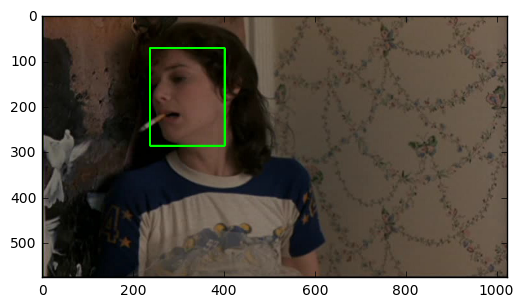

In [31]:
raw_img = cv2.imread('./hard.jpg')

refind_bboxes = tiny_face_detector(raw_img)

for r in refind_bboxes:
#     plt.imshow(cv2.cvtColor(raw_img[r[1]:r[3], r[0]:r[2]], cv2.COLOR_BGR2RGB))
#     plt.show()
    
    cv2.rectangle(raw_img, (r[0],r[1]), (r[2],r[3]), (0,255,0),3)
    
plt.imshow(cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB))
plt.show()

# Main Program

In [ ]:
minsize = 20

caffe_model_path = "./model"

threshold = [0.6, 0.7, 0.7]
factor = 0.709

#     caffe.set_mode_cpu()
caffe.set_mode_gpu()
PNet = caffe.Net(caffe_model_path+"/det1.prototxt", caffe_model_path+"/det1.caffemodel", caffe.TEST)
RNet = caffe.Net(caffe_model_path+"/det2.prototxt", caffe_model_path+"/det2.caffemodel", caffe.TEST)
ONet = caffe.Net(caffe_model_path+"/det3.prototxt", caffe_model_path+"/det3.caffemodel", caffe.TEST)

In [ ]:
# def main():
filename = 'D:/nhduong/MotionRecognition/data/AFEW/AFEW_6_2016/Val/Data/Fear/000142325.avi.mp4'
vid = imageio.get_reader(filename, 'ffmpeg')

emo_count = np.zeros((7, 1))

for num, img in enumerate(vid):
    # Face detection
    img_matlab = img.copy()
    tmp = img_matlab[:,:,2].copy()
    img_matlab[:,:,2] = img_matlab[:,:,0]
    img_matlab[:,:,0] = tmp

    # check rgb position
    tic()
    boundingboxes, points = detect_face(img_matlab, minsize, PNet, RNet, ONet, threshold, False, factor)
    toc()

    # Display the frame until new frame is available
    clear_output(wait=True)

    # Draw detected regions
    img = drawBoxes(img, boundingboxes)

    # Turn off the axis
    plt.axis('off')
    # Display the frame
    plt.suptitle('', fontsize=20)

    # There are some detected faces!
    if np.shape(boundingboxes)[0] > 0:
        boundingboxes = np.round(boundingboxes).astype(int)
        x1 = boundingboxes[:,0]
        y1 = boundingboxes[:,1]
        x2 = boundingboxes[:,2]
        y2 = boundingboxes[:,3]

        # Face segmentation
        face_img = img[y1[0]:y2[0], x1[0]:x2[0]]
        prob, label = predict_emotion_from_image(model, face_img)

        emo_count[label[0]] += 1

        # Show emotion label
        plt.suptitle(get_emotion(label), fontsize=20)


    plt.imshow(img)
    plt.show()

# Final emotion
# Display the frame until new frame is available
clear_output(wait=True)
# Turn off the axis
plt.axis('off')
# Display the frame
plt.suptitle('final emotion for the video: ' + get_emotion(emo_count), fontsize=20)
plt.imshow(img)
plt.show()

vid.close()

# return emo_count

In [ ]:
# if __name__ == "__main__":
#     emo_count = main()